Display skew, term structure, greeks, distribution of returns, statistical moments, vol smile/smirk, vol surface, IV vs RV

In [25]:
import numpy as  np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

In [26]:
# loading data
path = r"Data\AAPL_options.csv"
options_df = pd.read_csv(path)
options_df.head(2)

,date,expiration date,type,strike price,ask price,ask size,bid price,bid size,last price,volume,open interest,closing price,exp closing price,date div,exp date div
0,2016-01-04,2016-01-08,call,15.0,11.375,20.0,11.3,12.0,0.0,0.0,0.0,26.337,24.24,0.085246,0.09377
1,2016-01-04,2016-01-08,put,15.0,0.005,1400.0,0.0,0.0,0.0,0.0,0.0,26.337,24.24,0.085246,0.09377


In [27]:
# creating mid price
options_df["mid price"] = round((options_df["ask price"] + options_df["bid price"])/2, 5)
options_df.head(2)

,date,expiration date,type,strike price,ask price,ask size,bid price,bid size,last price,volume,open interest,closing price,exp closing price,date div,exp date div,mid price
0,2016-01-04,2016-01-08,call,15.0,11.375,20.0,11.3,12.0,0.0,0.0,0.0,26.337,24.24,0.085246,0.09377,11.3375
1,2016-01-04,2016-01-08,put,15.0,0.005,1400.0,0.0,0.0,0.0,0.0,0.0,26.337,24.24,0.085246,0.09377,0.0025


In [28]:
# concatenating call and put rows for the same price    
# call mid, put mid are columns 16 and 17 respectively
options_df["call mid"] = 0
options_df["put mid"] = 0
    
# boolean masks for call and put options in every second row
call_mask = (options_df.iloc[::2, 2] == "call").values
put_mask = (options_df.iloc[::2, 2] == "put").values

# indices of every second row
indices = np.arange(0, options_df.shape[0], 2)

# assign values based on call options
# if call, call mid will be assigned from mid price and put mid will be assigned from next mid price
options_df.iloc[indices[call_mask], 16] = options_df.iloc[indices[call_mask], 15].values
options_df.iloc[indices[call_mask], 17] = options_df.iloc[indices[call_mask] + 1, 15].values
# assign values based on put options
options_df.iloc[indices[put_mask], 17] = options_df.iloc[indices[put_mask], 15].values
options_df.iloc[indices[put_mask], 16] = options_df.iloc[indices[put_mask] + 1, 15].values

In [29]:
# reducing rows to every other and fixing index
options_df = options_df[options_df.index % 2 == 0]
options_df.index = np.arange(0, len(options_df))

# dropping unnecessary columns
options_df = options_df.drop(["bid price", "ask price", "last price",
"volume", "open interest", "exp closing price", "date div", "exp date div","type"], axis=1)

# creating DTE
T = (pd.to_datetime(options_df["expiration date"]) - pd.to_datetime(options_df["date"])).dt.days
options_df["DTE"] = T

# restricting DTE
options_df = options_df[options_df["DTE"] > 4]
options_df = options_df[options_df["DTE"] < 365]

# dropping rows with zero call and put mid
mask1 = options_df["call mid"] > 0
mask2 = options_df["put mid"] > 0
options_df = options_df[mask1 | mask2]
options_df.head(2)

,date,expiration date,strike price,ask size,bid size,closing price,mid price,call mid,put mid,DTE
55,2016-01-04,2016-01-15,8.5725,168.0,0.0,26.337,0.00125,17.75625,0.00125,11
56,2016-01-04,2016-01-15,8.9275,1436.0,0.0,26.337,0.00250,17.40625,0.00250,11


In [30]:
# creating new dataframe for date organization
df = pd.DataFrame()

# organizing based on dates
for header in ["DTE", "strike price", "closing price", "call mid", "put mid"]:
    df[header] = options_df.groupby("date")[header].apply(np.array)

# converting index to date column
if "date" not in df.columns:
    df = df.reset_index()

df["date"] = pd.to_datetime(df["date"])
df["terms"] = df["DTE"].apply(lambda x: sorted(set(x)))
df.head(1)

,date,DTE,strike price,closing price,call mid,put mid,terms
0,2016-01-04,"[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1...","[8.5725, 8.9275, 9.285, 9.6425, 10.0, 10.3575,...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[17.75625, 17.40625, 17.05, 16.7, 16.3375, 15....","[0.00125, 0.0025, 0.0025, 0.0025, 0.0025, 0.00...","[11, 18, 25, 32, 39, 46, 74, 102, 165, 193, 291]"


In [31]:
# for simplicity assuming interest rate is 0.05, will probably adjust later using cubic spline approach
# calculating implied volatility using root optimizer
from scipy import optimize
import scipy.stats as si

def calcimpliedvol(price, S, K, T, r=0.05):
    def bs_price(sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        fx = (S * si.norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * si.norm.cdf(d2, 0, 1)) - price
        return fx 
    def vega(sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        return S * np.sqrt(T) * si.norm.pdf(d1, 0, 1)
    
    try:
        #return optimize.brentq(bs_price, 0.00001, 20, maxiter=1000)
        return optimize.newton(bs_price, 0.3, vega, maxiter=1000)
    except:
        return np.NaN 
    
def compute_iv(price, S, K, T):
    return [calcimpliedvol(price, s, k, t) for price, s, k, t in zip(price, S, K, T)]

In [32]:
# getting df ready for IV calculation
df["T"] = df["DTE"].to_numpy() / 365

In [33]:
# performing IV calc on df
df1 = df.head(5)
df1["IV"] = list(map(compute_iv, df1["call mid"], df1["closing price"], df1["strike price"], df1["T"]))
# df1["IV"] = [np.round(x, 5) for x in df1["IV"]]

d:\Users\semic\Anaconda3\lib\site-packages\scipy\optimize\_zeros_py.py:305: RuntimeWarning: overflow encountered in double_scalars
  newton_step = fval / fder
C:\Users\semic\AppData\Local\Temp\ipykernel_3460\2451454553.py:8: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\semic\AppData\Local\Temp\ipykernel_3460\2451454553.py:13: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\semic\AppData\Local\Temp\ipykernel_3460\2451454553.py:8: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\semic\AppData\Local\Temp\ipykernel_3460\2451454553.py:13: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\semic\AppData\Local\Temp\ipykernel_3460\2523

C:\Users\semic\AppData\Local\Temp\ipykernel_3460\2034578682.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["IV by DTE"] = [groupy_by_dte(row["DTE"], row["IV"], row["terms"]) for idx, row in df1.iterrows()]
C:\Users\semic\AppData\Local\Temp\ipykernel_3460\2034578682.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["strike by DTE"] = [groupy_by_dte(row["DTE"], row["strike price"], row["terms"]) for idx, row in df1.iterrows()]


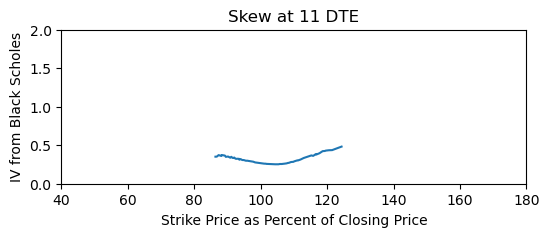

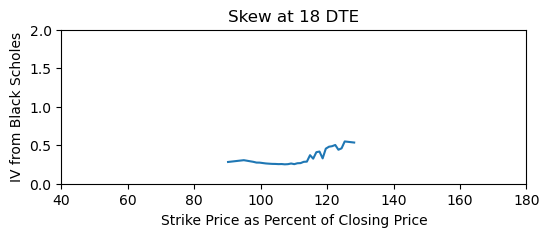

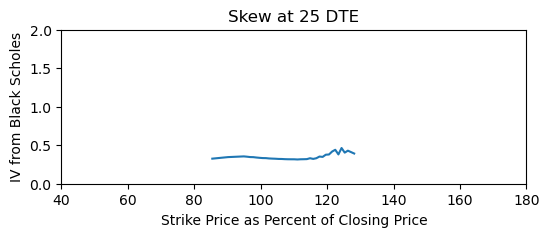

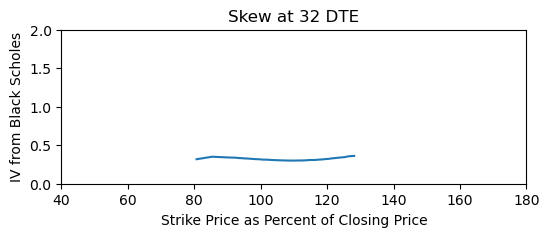

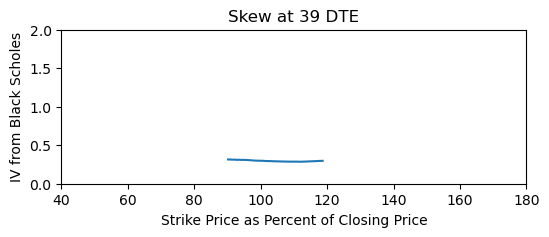

In [34]:
#graphing skew
def groupy_by_dte(dte, val, terms):
    grouped_mask = {}
    for i in terms:
        if i not in grouped_mask:
            grouped_mask[i] = []
        grouped_mask[i] = list(np.array(val)[dte == i])

    return list(grouped_mask.values())


df1["IV by DTE"] = [groupy_by_dte(row["DTE"], row["IV"], row["terms"]) for idx, row in df1.iterrows()]
df1["strike by DTE"] = [groupy_by_dte(row["DTE"], row["strike price"], row["terms"]) for idx, row in df1.iterrows()]

num_of_graphs = 5
for i in range(num_of_graphs):
    x = np.round(100 * np.array(df1.loc[0, "strike by DTE"][i]) / df1.loc[0, "closing price"][i], 5)
    y = df1.loc[0, "IV by DTE"][i]
    plt.figure(i, figsize=(6,2))
    plt.plot(x, y)
    plt.xlim(40, 180)
    plt.ylim(0, 2)
    DTE = df1.loc[0, "terms"][i]
    plt.title(f"Skew at {DTE} DTE")
    plt.xlabel("Strike Price as Percent of Closing Price")
    plt.ylabel("IV from Black Scholes")

C:\Users\hollanderj\AppData\Local\Temp\ipykernel_13396\3713327667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["close adj strike"] = df1["strike price"] / df1["closing price"]
C:\Users\hollanderj\AppData\Local\Temp\ipykernel_13396\3713327667.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["atm strike index"] = list(map(index_closest_to, np.full(len(df1["close adj strike"]), moneyness_val), df1["close adj strike"]))
C:\Users\hollanderj\AppData\Local\Temp\ipykernel_13396\3713327667.py:14: 

,date,DTE,strike price,closing price,call mid,put mid,terms,T,IV,IV by DTE,strike by DTE,close adj strike,atm strike index
0,2016-01-04,"[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1...","[8.5725, 8.9275, 9.285, 9.6425, 10.0, 10.3575,...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[17.75625, 17.40625, 17.05, 16.7, 16.3375, 15....","[0.00125, 0.0025, 0.0025, 0.0025, 0.0025, 0.00...","[11, 18, 25, 32, 39, 46, 74, 102, 165, 193, 291]","[0.03014, 0.03014, 0.03014, 0.03014, 0.03014, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[8.5725, 8.9275, 9.285, 9.6425, 10.0, 10.3575...","[0.32549265292174506, 0.33897178873827694, 0.3...","[73, 148, 188, 233, 276, 308, 331, 357, 387, 4..."
1,2016-01-05,"[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...","[8.5725, 8.9275, 9.285, 9.6425, 10.0, 10.3575,...","[25.677, 25.677, 25.677, 25.677, 25.677, 25.67...","[17.1125, 16.75, 16.4, 16.0375, 15.67875, 15.3...","[0.00125, 0.0025, 0.0025, 0.0025, 0.0025, 0.00...","[10, 17, 24, 31, 38, 45, 73, 101, 164, 192, 290]","[0.0274, 0.0274, 0.0274, 0.0274, 0.0274, 0.027...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[8.5725, 8.9275, 9.285, 9.6425, 10.0, 10.3575...","[0.33385909568874866, 0.34768469836818944, 0.3...",[67]
2,2016-01-06,"[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ...","[8.5725, 8.9275, 9.285, 9.6425, 10.0, 10.3575,...","[25.175, 25.175, 25.175, 25.175, 25.175, 25.17...","[16.6, 16.24375, 15.8875, 15.525, 15.175, 14.8...","[0.00125, 0.0025, 0.0025, 0.0025, 0.0025, 0.00...","[9, 16, 23, 30, 37, 44, 72, 100, 163, 191, 289]","[0.02466, 0.02466, 0.02466, 0.02466, 0.02466, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[8.5725, 8.9275, 9.285, 9.6425, 10.0, 10.3575...","[0.3405163853028798, 0.35461767626613705, 0.36...","[62, 145, 183, 229, 276, 312, 335, 361, 391, 4..."
3,2016-01-07,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[8.5725, 8.9275, 9.285, 9.6425, 10.0, 10.3575,...","[24.113000000000003, 24.113000000000003, 24.11...","[15.56875, 15.2, 14.8475, 14.49125, 14.125, 13...","[0.00125, 0.00375, 0.00375, 0.0025, 0.00125, 0...","[8, 15, 22, 29, 36, 43, 50, 71, 99, 162, 190, ...","[0.02192, 0.02192, 0.02192, 0.02192, 0.02192, ...","[2.961124353222518, 2.4439932560228956, 2.5265...","[[2.961124353222518, 2.4439932560228956, 2.526...","[[8.5725, 8.9275, 9.285, 9.6425, 10.0, 10.3575...","[0.3555136233566955, 0.3702359722971011, 0.385...","[61, 347]"
4,2016-01-08,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[8.5725, 8.9275, 9.285, 9.6425, 10.0, 10.3575,...","[24.24, 24.24, 24.24, 24.24, 24.24, 24.24, 24....","[15.68125, 15.33125, 14.96875, 14.61625, 14.25...","[0.00125, 0.0025, 0.0025, 0.0025, 0.00375, 0.0...","[7, 14, 21, 28, 35, 42, 49, 70, 98, 161, 189, ...","[0.01918, 0.01918, 0.01918, 0.01918, 0.01918, ...","[2.769355468083506, 2.845943003418371, 2.53276...","[[2.769355468083506, 2.845943003418371, 2.5327...","[[8.5725, 8.9275, 9.285, 9.6425, 10.0, 10.3575...","[0.3536509900990099, 0.3682962046204621, 0.383...","[62, 280, 348]"


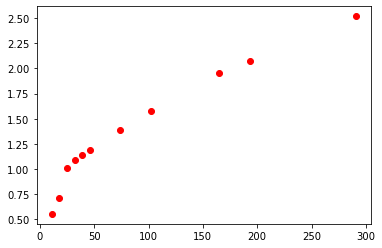

In [25]:
# finding term structure
# creating strike divided by close column
df1["close adj strike"] = df1["strike price"] / df1["closing price"]

# finding closest to the money strike (ATM)
def index_closest_to(val, arr):
    arr = np.array(arr)
    closest = np.max(arr[arr < val])
    return np.where(arr == closest)

moneyness_val = 1 # 1 is ATM, 0.5 would be ITM, 1.5 would be OTM
#df1["moneyness_val"] = list(map(np.full, len(df1["close adj strike"]), moneyness_val))
df1["atm strike index"] = list(map(index_closest_to, np.full(len(df1["close adj strike"]), moneyness_val), df1["close adj strike"]))
df1["atm strike index"] = [np.array(x).flatten() for x in df1["atm strike index"]]

x = np.array(df1.loc[0, "DTE"])[df1.loc[0, "atm strike index"]]
y = np.array(df1.loc[0, "call mid"])[df1.loc[0, "atm strike index"]]
plt.plot(x, y, "ro")

df1.head()

Text(0.5, 1.0, 'Returns vs Normal Distribution')

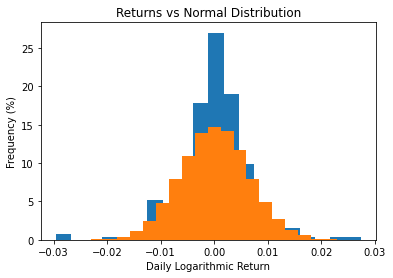

In [23]:
# distribution of returns
import random

rand = [random.normalvariate(0.00016, 0.0064) for i in range(10000)] 

close = pd.Series([x[0] for x in df["closing price"]])
day = [(pd.to_datetime(x) - datetime(2016, 1, 1,)).days for x in df["date"]]
logret = np.log10(close) - np.log10(close.shift(1))
plt.hist(logret[1:], 20, weights=100*np.ones(len(logret[1:]))/len(logret))
plt.hist(rand, 20, weights=100*np.ones(len(rand))/len(rand))
plt.ylabel("Frequency (%)")
plt.xlabel("Daily Logarithmic Return")
plt.title("Returns vs Normal Distribution")

In [24]:
# statistic moments
if len(logret) == 252:
    logret = logret[1:]

mean = logret.mean()
var = logret.var()
skew = logret.skew()
kurtosis = logret.kurtosis()

print(mean)
print(var)
print(np.sqrt(var))
print(skew)
print(kurtosis)

0.00016397316942111511
4.1160615794899866e-05
0.006415653964710056
-0.30793008225744223
4.366096538844962


[0.9999897932036521, 2.583418547213839e-05, -8.073182960043247e-05, 0.0016146365920086496]


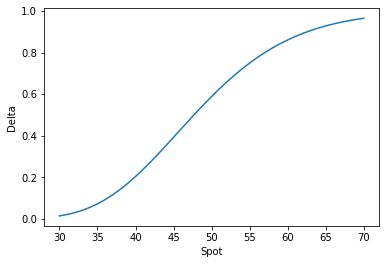

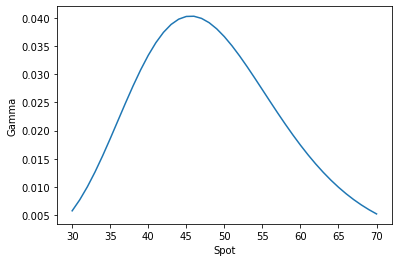

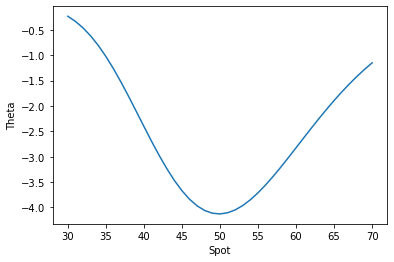

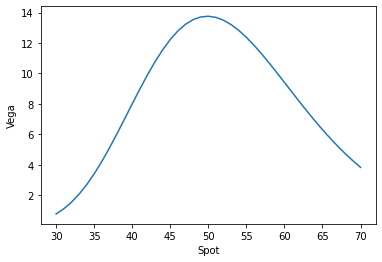

In [28]:
# greeks (delta, gamma, theta, vega)
# one function for simplicity
def greeks(S, K, T, sigma, r=0.05, type="call"):
    d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    gamma = si.norm.pdf(d1, 0, 1) / (S * sigma * np.sqrt(T))
    theta = - (S * si.norm.pdf(d1, 0, 1) * sigma) / (2 * np.sqrt(T))
    - r * K * np.exp(-r * T) * si.norm.cdf(d2, 0, 1)
    vega = S * np.sqrt(T) * si.norm.pdf(d1, 0, 1)
    delta = si.norm.cdf(d1, 0, 1)

    if type != "call":
        theta += r * K * np.exp(-r * T)
        delta -= 1



    try:
        return [delta, gamma, theta, vega]
    except: 
        return np.NaN

print(greeks(50, 50, 0.5, 0.05, 0.3)) 

x = range(30, 71)
deltas = [val[0] for val in [greeks(i, 50, 0.5, 0.3) for i in x]]
gammas = [val[1] for val in [greeks(i, 50, 0.5, 0.3) for i in x]]
thetas = [val[2] for val in [greeks(i, 50, 0.5, 0.3) for i in x]]
vegas = [val[3] for val in [greeks(i, 50, 0.5, 0.3) for i in x]]

ys = [deltas, gammas, thetas, vegas]
y_names = ["Delta", "Gamma", "Theta", "Vega"]
for i in range(4):
    plt.figure()
    plt.plot(x, ys[i])
    plt.xlabel("Spot")
    plt.ylabel(y_names[i])

In [37]:
def greeks_arr(S, K, T, sigma):
    return [greeks(S, K, T, sigma) for S, K, T, sigma in zip(S, K, T, sigma)]

df1["greeks"] = list(map(greeks_arr, df1["closing price"], df1["strike price"], df1["T"], df1["IV"]))

C:\Users\hollanderj\AppData\Local\Temp\ipykernel_18684\2183275689.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["greeks"] = list(map(greeks_arr, df1["closing price"], df1["strike price"], df1["T"], df1["IV"]))
